In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('./input/.'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Chest X-ray (Covid-19 & Pneumonia)
Dataset contains chest x-ray images of Covid-19, Pneumonia and normal patients.

Last Updated: a month ago
About this Dataset
Context

COVID-19 (coronavirus disease 2019) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), a strain of coronavirus. The first cases were seen in Wuhan, China, in late December 2019 before spreading globally. The current outbreak was officially recognized as a pandemic by the World Health Organization (WHO) on 11 March 2020.
Currently Reverse transcription polymerase chain reaction (RT-PCR) is used for diagnosis of the COVID-19. X-ray machines are widely available and provide images for diagnosis quickly so chest X-ray images can be very useful in early diagnosis of COVID-19.
Content

Dataset is organized into 2 folders (train, test) and both train and test contain 3 subfolders (COVID19, PNEUMONIA, NORMAL). DataSet contains total 6432 x-ray images and test data have 20% of total images.
Acknowledgements

Images are collected from various publicly available resources. If you use the data for research please give credit to authors:
Sources:

    https://github.com/ieee8023/covid-chestxray-dataset
    https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
    https://github.com/agchung

Inspiration

Application of Artificial Intelligence (AI) techniques with radiological images for COVID-19 diagnosis.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17809296101737696974
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4804834392320775986
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 323614138495846716
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5522353024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16165887228943632174
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical

In [3]:
#read DataSet
TrianImage="./input/chest-xray-covid19-pneumonia/Data/train/"
TestImage="./input/chest-xray-covid19-pneumonia/Data/test/"


print(TrianImage)
print(TestImage)

./input/chest-xray-covid19-pneumonia/Data/train/
./input/chest-xray-covid19-pneumonia/Data/test/


In [4]:
#to get all image names in train file
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")
Normalimages = os.listdir(TrianImage + "/NORMAL")
COVID19images = os.listdir(TrianImage + "/COVID19")






# Explore the Data

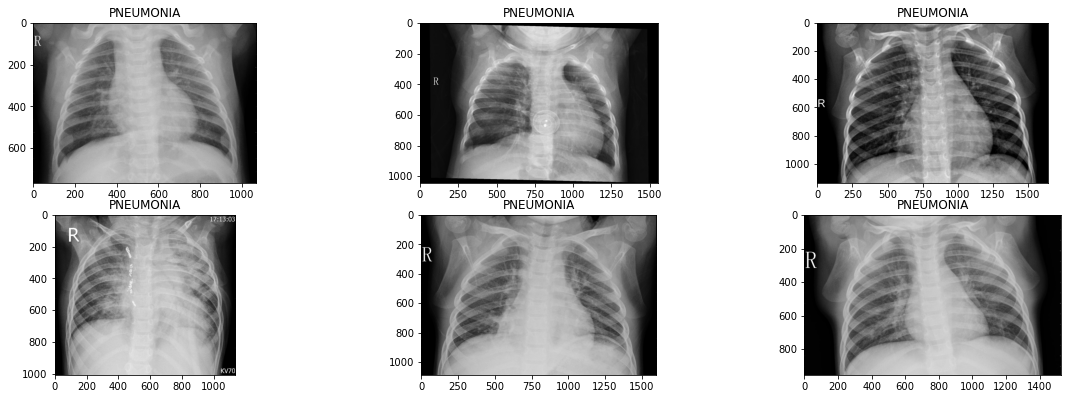

In [32]:
#plot to show the size of some image
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()


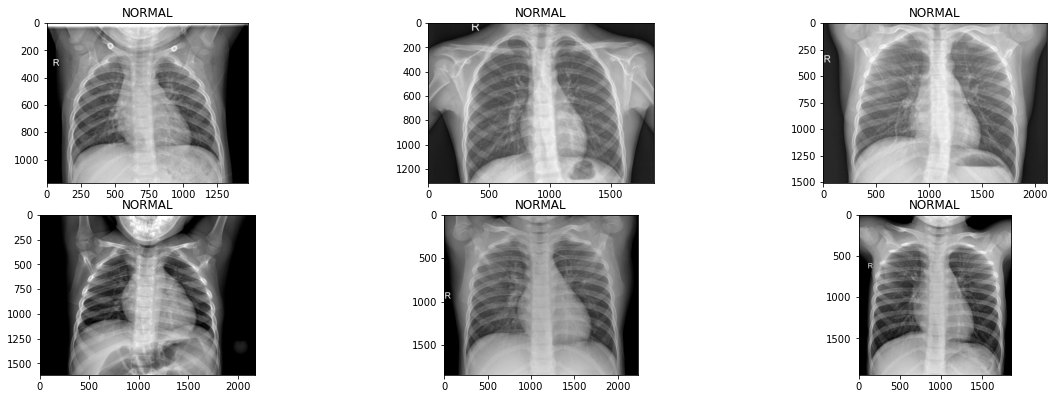

In [33]:

#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()


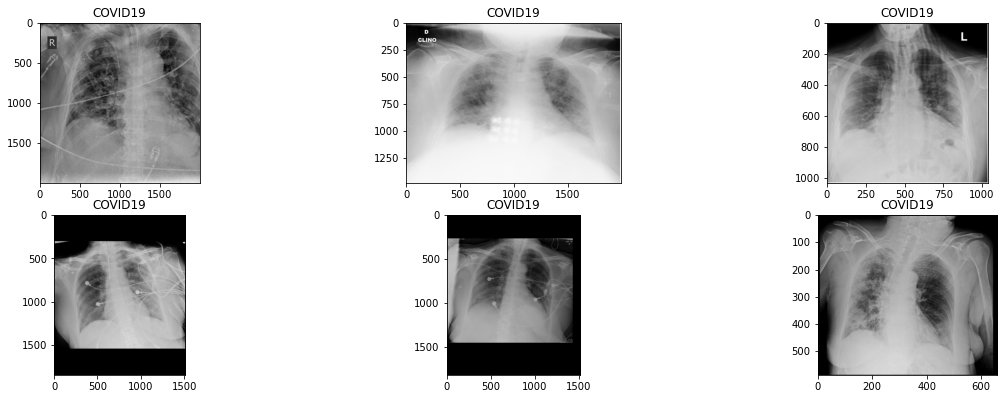

In [34]:
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

# ImageDataGenerator (DataAugmentation )

We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1.
This will facilitate model training by standardizing the input distribution

The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
We will want this because the pre-trained model that we'll use requires three-channel inputs.

In [35]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator =train_datagen.flow_from_directory(
     TrianImage,
     batch_size= 256,
     shuffle=shuffle,
     target_size=(300, 300)

)

test_generator =train_datagen.flow_from_directory(
     TestImage,
     batch_size= 50,
     shuffle=shuffle,
     target_size=(300, 300)

)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [36]:
trainShape=train_generator.__getitem__(0)[0].shape
testShape=test_generator.__getitem__(0)[0].shape

In [37]:
#Shape of Data
print("Train Shape \n",trainShape)
print("Test Shape \n",testShape)

Train Shape 
 (256, 300, 300, 3)
Test Shape 
 (50, 300, 300, 3)


In [38]:
Labels={'NORMAL':0,'PNEUMONIA':1,'COVID19':2}

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
        
        
#Test        
print(getCode('COVID19'))
print(getLabel(1))

2
PNEUMONIA


# Explore Data After DataAugmentation and standardizing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


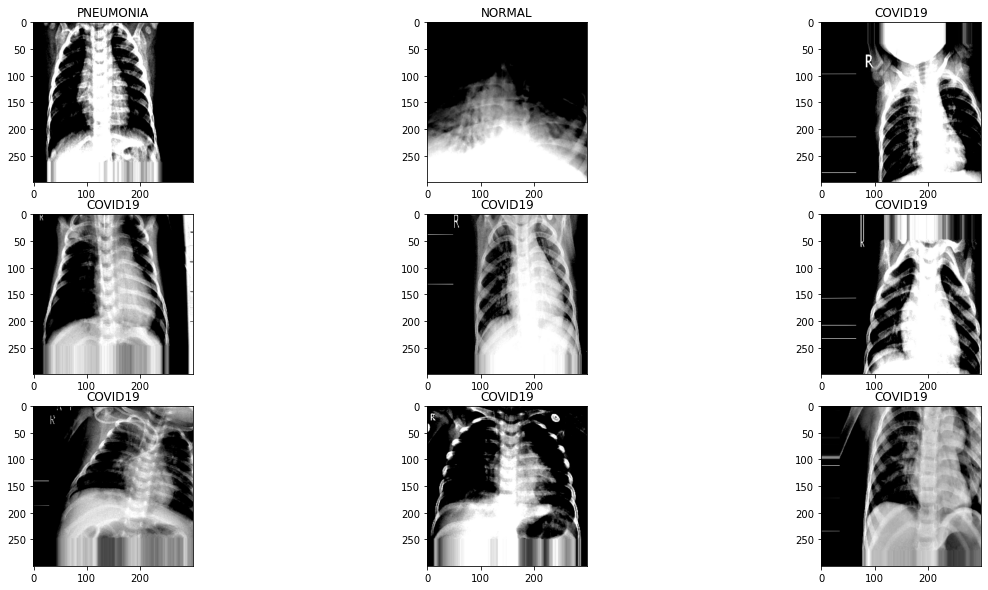

In [39]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_generator.__getitem__(0)[0][i])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(0)[1][i])) )

# Another Way To Load Data

In [19]:
#Reading image data
import glob as gb
import cv2  
sizeImage=300 # to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y


#get train data
X_train, y_train = getData(TrianImage,sizeImage)
# get test data
X_test , y_test = getData(TestImage,sizeImage)

In [40]:
print("X_train Shape        ",X_train.shape)
print("X_test Shape         ",X_test.shape)


X_train Shape         (5144, 300, 300, 3)
X_test Shape          (1288, 300, 300, 3)


In [21]:
# #Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)



#Convert y_train to categorical
y_test=to_categorical(y_test,3)
print("y_test ",y_test.shape)


y_train  (5144, 3)
y_test  (1288, 3)


In [25]:
# summarize class distribution
import collections
counter = collections.Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


In [44]:
np.unique(y_train)

array([0., 1.], dtype=float32)

In [43]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

/home/mohcine/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0. 1.], y=[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TypeError: unhashable type: 'numpy.ndarray'

# Build Model

In [16]:
#load weight
Network_Weight="./input/densenet-keras/DenseNet-BC-169-32-no-top.h5"
print(Network_Weight)

./input/densenet-keras/DenseNet-BC-169-32-no-top.h5


In [17]:
 
from tensorflow.keras.applications.densenet import DenseNet169
pre_trained_model = DenseNet169(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights
pre_trained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [18]:
# class CustomModel(keras.Model):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.input_layer = keras.layers.Flatten(input_shape=(28,28))
#         self.hidden1 = keras.layers.Dense(200, activation='relu')
#         self.hidden2 = keras.layers.Dense(100, activation='relu')
#         self.hidden3 = keras.layers.Dense(60, activation='relu')
#         self.output_layer = keras.layers.Dense(10, activation='softmax')
#         self.dropout_layer = keras.layers.Dropout(rate=0.2)
    
#     def call(self, input):
#         input_layer = self.input_layer(input)
#         input_layer = self.dropout_layer(input_layer)
#         hidden1 = self.hidden1(input_layer)
#         hidden1 = self.dropout_layer(hidden1)
#         hidden2 = self.hidden2(hidden1)
#         hidden2 = self.dropout_layer(hidden2)
#         hidden3 = self.hidden3(hidden2)
#         hidden3 = self.dropout_layer(hidden3)
#         output_layer = self.output_layer(hidden3)
#         return output_layer
# model = CustomModel()
# sgd = keras.optimizers.SGD(lr=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [19]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)


x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)
       

model = Model( pre_trained_model.input, x) 

print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

## The Keras API

Adding early stopping to overfit deep learning neural network models consist of:
- Monitor the performance of a model during training using the Keras API.
- Create and configure early stopping and model checkpoint callbacks using the Keras API.
- Reduce overfitting by adding an early stopping to an existing model.

### Using Callbacks in Keras

Callbacks provide a way to execute code and interact with the training model process automatically.

Callbacks can be provided to the fit() function via the “callbacks” argument.

### Evaluating a Validation Dataset in Keras

Early stopping requires that a validation dataset is evaluated during training.

This can be achieved by specifying the validation dataset to the fit() function when training your model.

There are two ways of doing this.

The first involves you manually splitting your training data into a train and validation dataset and specifying the validation dataset to the fit() function via the validation_data argument. For example:

    model.fit(train_X, train_y, validation_data=(val_x, val_y))

Alternately, the fit() function can automatically split your training dataset into train and validation sets based on a percentage split specified via the validation_split argument.

The validation_split is a value between 0 and 1 and defines the percentage amount of the training dataset to use for the validation dataset. For example:

    model.fit(train_X, train_y, validation_split=0.3)

In both cases, the model is not trained on the validation dataset. Instead, the model is evaluated on the validation dataset at the end of each training epoch.

Monitoring Model Performance

The loss function chosen to be optimized for your model is calculated at the end of each epoch.

### To callbacks, this is made available via the name “loss.”

If a validation dataset is specified to the fit() function via the validation_data or validation_split arguments, then the loss on the validation dataset will be made available via the name “val_loss.”

Additional metrics can be monitored during the training of the model.

They can be specified when compiling the model via the “metrics” argument to the compile function. This argument takes a Python list of known metric functions, such as ‘mse‘ for mean squared error and ‘accuracy‘ for accuracy. For example:

    model.compile(..., metrics=['accuracy'])

If additional metrics are monitored during training, they are also available to the callbacks via the same name, such as ‘accuracy‘ for accuracy on the training dataset and ‘val_accuracy‘ for the accuracy on the validation dataset. Or, ‘mse‘ for mean squared error on the training dataset and ‘val_mse‘ on the validation dataset.

# ReduceLROnPlateau

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.


In [21]:
epochs = 5
history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] , epochs=epochs)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
20/20 [==============================] - 281s 14s/step - loss: 2.1286 - accuracy: 0.6831 - lr: 0.0010
Epoch 2/5
20/20 [==============================] - 291s 15s/step - loss: 0.3220 - accuracy: 0.8552 - lr: 0.0010
Epoch 3/5
20/20 [==============================] - 279s 14s/step - loss: 0.2054 - accuracy: 0.8991 - lr: 0.0010
Epoch 4/5
20/20 [==============================] - 276s 14s/step - loss: 0.1671 - accuracy: 0.9198 - lr: 0.0010
Epoch 5/5
20/20 [==============================] - 271s 14s/step - loss: 0.1366 - accuracy: 0.9313 - lr: 0.0010


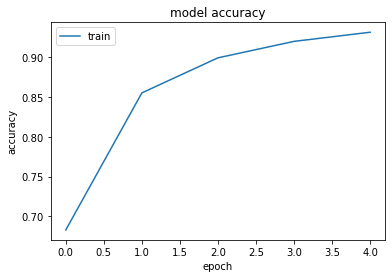

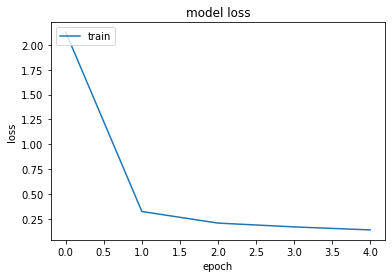

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

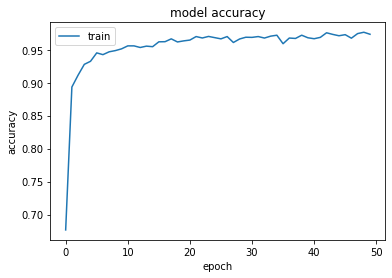

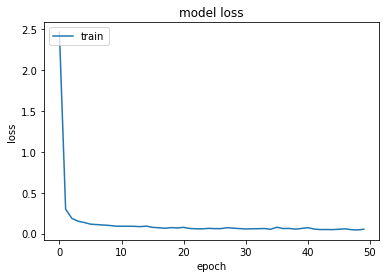

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [35]:
test_generator

In [23]:
#Evaluate Model
model.evaluate(test_generator)

26/26 [==============================] - 56s 2s/step - loss: 0.1218 - accuracy: 0.9394


[0.12182948738336563, 0.9394409656524658]

In [24]:
model.save('modelCovid19___current_epochs_5.h5')

In [25]:
#prediction
pred=model.predict(test_generator)

In [26]:
print(len(pred))

1288


In [27]:
y_test=[]
for i in range(26):
    y_test.extend(test_generator.__getitem__(i)[1])

In [28]:
print(len(y_test))
y_test=np.array(y_test)

1288


In [29]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

In [30]:
print("pred \n",len(pred))
print("y_test \n",len(y_test))

pred 
 1288
y_test 
 1288


In [31]:
print("y_test \n",y_test)
print("pred \n",pred)

y_test 
 [2 2 2 ... 2 2 2]
pred 
 [1 1 2 ... 2 1 2]


In [28]:
#confusion_matrix to check in accuracy 
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(pred,y_test)
print(cm)

NameError: name 'pred' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


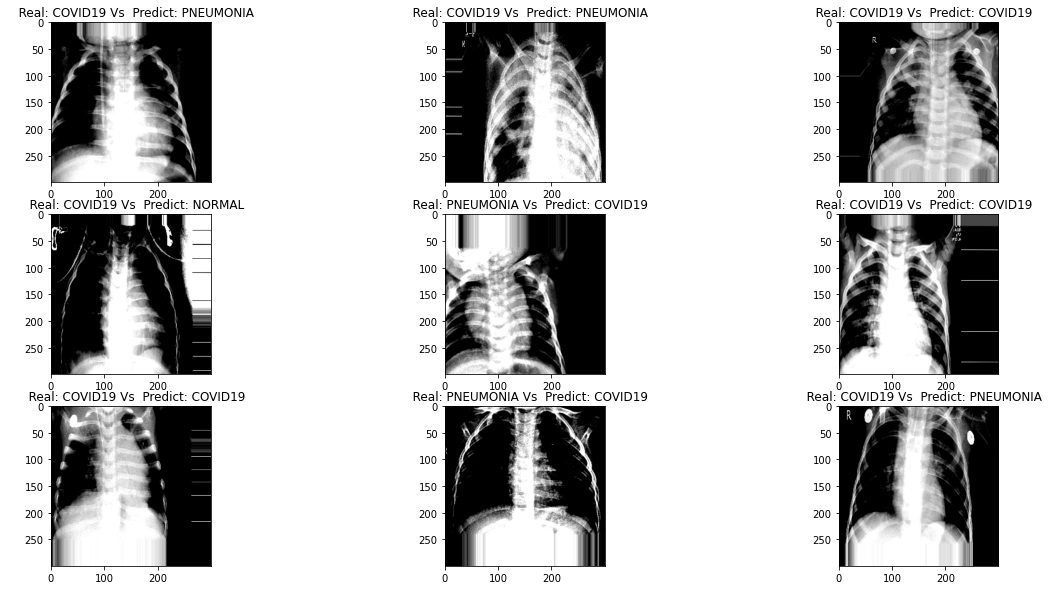

In [33]:
plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_generator.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")

In [ ]:
test_generator

In [ ]:
#lto load model
from tensorflow.keras.models import load_model
loadedModel=load_model("modelCovid19___current.h5")

In [ ]:
loadedModel.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])
loadedModel.evaluate(test_generator)

In [ ]:
# from sklearn.metrics import plot_confusion_matrix
# plt = plot_confusion_matrix(model, y_test, pred)

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot()

plt.show()

NameError: name 'cm' is not defined